In [1]:
# basics
from datetime import datetime
import time
import lightgbm
from tqdm import tqdm


#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import regplot

# ml shit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

# models
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

# relative imports
from get_feats import get_features

SEED = 2021
data_root = "../data/"

In [2]:
df_features_targets = get_features(data_root)
df_features_targets.drop(columns=["Target_eth", "beta_eth"], inplace = True)

y = df_features_targets[["Target_btc"]].to_numpy().squeeze()
X =df_features_targets.drop(columns=["Target_btc"], inplace=False).to_numpy()
X_sm, y_sm = X[:90000], y[:90000]   

In [ ]:

# random search parameters
# the parametersrare a copy of 渡辺卒論
def random_search_lgbm(X, y, params_space):
    params_log = {}
    iteration = 10
    cv = TimeSeriesSplit()
    for i in tqdm(range(iteration)):
        params = {}
        for key in params_space.keys():
            param_list = params_space[key]
            length = len(param_list)
            idx =np.random.randint(0,length) 
            params.update({key:param_list[idx]})
            # fit model to data
        
        model = LGBMRegressor(**params)
        for train_idx, test_idx, in cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).squeeze()
            coef_score = np.corrcoef(y_pred, y_test)[0][1]
            rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
        params_log.update({i:[coef_score, rmse_score, params]})

    sorted_by_coef=sorted(params_log.items(), key = lambda item: item[1][0], reverse=True)
    sorted_by_rmse=sorted(params_log.items(), key = lambda item: item[1][1])
    
    return sorted_by_coef, sorted_by_rmse


# best for coef(rmse doesn't really change)
"""{'max_depth': 4,
    'min_data_in_leaf': 20,
    'learning_rate': 0.01,
    'num_leaves': 40,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'random_state': 2021,
    'reg_alpha': 1.2,
    'reg_lambda': 1.4}"""
params_space = {
        "max_depth":[4, 5, 6],
        "min_data_in_leaf":[15, 20, 25],
        "learning_rate":[0.01, 0.005],
        "num_leaves":[25, 30, 35, 40],
        "boosting_type":["gbdt"],
        "objective":["regression"],
        "random_state":[2021],
        "reg_alpha":[1, 102],
        "reg_lambda":[1, 1.2, 1.4]
        }

# sorted_by_coef, sorted_by_rmse = random_search_lgbm(X, y, params_space)
##### rmse got lower than baseline(model=LGBMRegressor), however coef got worse
# print("\n".join(sorted_by_rmse.items())) 
# print("\n".join(sorted_by_coef.items()))

NameError: name 'X' is not defined

In [3]:
final_params= {'max_depth': 4,
    'min_data_in_leaf': 20,
    'learning_rate': 0.01,
    'num_leaves': 40,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'random_state': 2021,
    'reg_alpha': 1.2,
    'reg_lambda': 1.4}

model = LGBMRegressor(**final_params)
model.fit(X_sm, y_sm)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMRegressor(learning_rate=0.01, max_depth=4, min_data_in_leaf=20,
              num_leaves=40, objective='regression', random_state=2021,
              reg_alpha=1.2, reg_lambda=1.4)

ImportError: You must install graphviz and restart your session to plot tree.

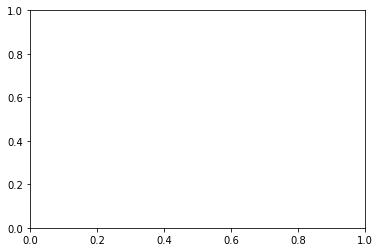

In [4]:
lightgbm.plot_tree(model)
plt.show()

In [4]:
# Time split validation for LightGBM, LinearRegressor, SVR

cv = TimeSeriesSplit(n_splits=5)
lgbm = LGBMRegressor()
lr = LinearRegression()
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# coef_scores_lgbm = []
# rmse_scores_lgbm = []
# coef_scores_lr = []
# rmse_scores_lr = []

# compute cv and rmse, coef scores for lgbm, lr, svr models
def cv_scores(X, y):

    coef_scores = {"lgbm":[], "lr":[], "svr":[]}
    rmse_scores = {"lgbm":[], "lr":[], "svr":[]}
    for train_idx, test_idx, in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        print(X_train.shape)

        lgbm.fit(X_train, y_train)
        lr.fit(X_train, y_train)
        regr.fit(X_train, y_train)

        y_pred_lgbm = lgbm.predict(X_test).squeeze()
        y_pred_lr = lr.predict(X_test).squeeze()
        y_pred_svr = regr.predict(X_test).squeeze()
        print("y_pred_svr.shape >>:", y_pred_svr.shape)
        print("y_pred_svr.isna.sum >>:", np.sum(np.isnan(y_test)))
        print("y_test.isna.sum", np.sum(np.isnan(y_pred_svr)))     
        
        coef_scores["lgbm"].append(np.corrcoef(y_pred_lgbm, y_test)[0][1])
        coef_scores["lr"].append(np.corrcoef(y_pred_lr, y_test)[0][1])
        coef_scores["svr"].append(np.corrcoef(y_pred_svr, y_test)[0][1])

        rmse_scores["lgbm"].append(np.sqrt(mean_squared_error(y_pred_lgbm, y_test)))
        rmse_scores["lr"].append(np.sqrt(mean_squared_error(y_pred_lr, y_test)))
        rmse_scores["svr"].append(np.sqrt(mean_squared_error(y_pred_svr, y_test)))

    return coef_scores, rmse_scores
        # coef_scores_lgbm.append(np.corrcoef(y_pred_lgbm, y_test)[0][1])
        # rmse_scores_lgbm.append(np.sqrt(mean_squared_error(y_pred_lgbm, y_test)))
        # coef_scores_lr.append(np.corrcoef(y_pred_lr, y_test)[0][1])
        # rmse_scores_lr.append(np.sqrt(mean_squared_error(y_pred_lr, y_test)))

In [5]:
coef_scores, rmse_scores = cv_scores(X_sm, y_sm)
models = ["lgbm", "lr", "svr"]
for model in models:
    print(f"{model}_coef_scores >>:", sum(coef_scores[model]))
    print(coef_scores[model])
for model in models:
    print(f"{model}_rmse_scores >>:", sum(rmse_scores[model]))


(15000, 13)
y_pred_svr.shape >>: (15000,)
y_pred_svr.isna.sum >>: 0
y_test.isna.sum 0
(30000, 13)


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


y_pred_svr.shape >>: (15000,)
y_pred_svr.isna.sum >>: 0
y_test.isna.sum 0
(45000, 13)


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


y_pred_svr.shape >>: (15000,)
y_pred_svr.isna.sum >>: 0
y_test.isna.sum 0
(60000, 13)


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


y_pred_svr.shape >>: (15000,)
y_pred_svr.isna.sum >>: 0
y_test.isna.sum 0
(75000, 13)


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


y_pred_svr.shape >>: (15000,)
y_pred_svr.isna.sum >>: 0
y_test.isna.sum 0
lgbm_coef_scores >>: 0.1315201309297373
[0.028443932239353646, 0.05304022149645442, 0.01058663525631585, 0.01697564820329782, 0.022473693734315583]
lr_coef_scores >>: 0.25963029319992237
[0.024406257207902366, 0.0791974686790663, 0.012543804090438173, 0.0360797429361121, 0.10740302028640342]
svr_coef_scores >>: nan
[nan, nan, nan, nan, nan]
lgbm_rmse_scores >>: 0.009833042422863168
lr_rmse_scores >>: 0.00915064093612973
svr_rmse_scores >>: 0.012286916798059766


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


lgbm_coef_scores >>: 0.03260839615236024
lr_coef_scores >>: 0.15899542915463533
svr_coef_scores >>: nan
lgbm_rmse_scores >>: 0.007897018856831799
lr_rmse_scores >>: 0.006672486025234611
svr_rmse_scores >>: 0.03511887093703035

In [ ]:
0.01918597934749267,
   0.0013507460664068677,

In [53]:
sum(coef_scores_lr), sum(coef_scores_lgbm), sum(rmse_scores_lr), sum(rmse_scores_lgbm)

(0.15899542915463533,
 0.03260839615236024,
 0.006672486025234611,
 0.007897018856831799)

In [46]:
coef_scores

[-0.0006014308185926689,
 0.013231169959288098,
 0.0017891720452698722,
 0.015268104787911473,
 0.002921380178483465]